## Import Statements

In [2]:
import copy

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [3]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### CLA Data

In [4]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
cla_2015.dropna(axis='rows', how='any', inplace=True)
cla_2016.dropna(axis='rows', how='any', inplace=True)
cla_2017.dropna(axis='rows', how='any', inplace=True)
cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample, ffill and bfill
cla_2015 = cla_2015.resample('D').mean()
cla_2015.ffill(inplace=True)
cla_2015.bfill(inplace=True)

for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1

cla_2016 = cla_2016.resample('D').mean()
cla_2016.ffill(inplace=True)
cla_2016.bfill(inplace=True)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1

cla_2017 = cla_2017.resample('D').mean()
cla_2017.ffill(inplace=True)
cla_2017.bfill(inplace=True)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1

cla_2018 = cla_2018.resample('D').mean()
cla_2018.ffill(inplace=True)
cla_2018.bfill(inplace=True)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1
        
# only keep the dates of the official sampling season of each year
cla_2015 = cla_2015[(cla_2015.index >= '2015-5-19') & (cla_2015.index <= '2015-9-4')]
cla_2016 = cla_2016[(cla_2016.index >= '2016-5-25') & (cla_2016.index <= '2016-9-4')]
cla_2017 = cla_2017[(cla_2017.index >= '2017-5-25') & (cla_2017.index <= '2017-9-4')]
cla_2018 = cla_2018[(cla_2018.index >= '2018-5-25') & (cla_2018.index <= '2018-9-4')]

### MDCP Data

In [5]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

### Weather Data

In [6]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
# weather.dropna(axis='rows', how='any', inplace=True)
weather = weather.iloc[:-1]  # remove last entry since it has NaN in REPORTTPYE

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()
weather.ffill(inplace=True)
weather.bfill(inplace=True)

## Join CLA, MDCP, and Weather Data

In [7]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
                
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
data['DAILYPrecip_one_day'] = precip.shift(1)
data['DAILYPrecip_three_day'] = precip.rolling(3).sum()
data['DAILYPrecip_one_week'] = precip.rolling(7).sum()

data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
data['algalBloomSheen_three_day'] = data['algalBloomSheen'].rolling(3).sum()
data['algalBloomSheen_one_week'] = data['algalBloomSheen'].rolling(7).sum()

data.dropna(axis='rows', how='any', inplace=True)

labels = data[['algalBloomSheen']]
data = data.drop(['algalBloom', 'algalBloomSheen'], axis='columns')

## Define Models

In [8]:
logic = LogisticRegression(    # gives more false positives, but not so many false negatives!!!!!
    penalty='l1',              # this model might be better without weather data actually
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

svc = SVC(                     # gives even slightly fewer false negatives than logic
    C=1,
    kernel='poly',
    degree=6,
    gamma='auto',
    coef0=1,
    probability=True,
    tol=0.001,
    class_weight='balanced',
    max_iter=10000
)

rfc = RandomForestClassifier(       # BEST MODEL
    n_estimators=100,
    max_depth=6,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced'
)

mlp = MLPClassifier(
    hidden_layer_sizes=(20, 50, 50, 20),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=8,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    tol=0.0001,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    n_iter_no_change=10
)

model = rfc

########################################
########################################
########################################
# TODO TRY PARAMETER TUNING THE SVC AND RFC, WILL POLY SVC WORK??
# TODO TRY CHANGING ROLLING AND SHIFTED BOOLEAN PRECIP DATA TO ACTUAL AMOUNTS   -- DONE!!
# TODO TRY LOG TRANSFORMS AND OTHERWISE ON SOME FEATURES
# TODO CROSS VALIDATED TRAINING CURVE                                 -- NOT APPLICABLE!!
# TODO TRY TRAINING ON ALL DATA BEFORE 2018, AND TEST ON DATA AFTER   -- DONE!!
# TODO TRY USING DATA ONLY FROM SAMPLING SEASON
# TODO TRY USING 2014 DATA
# TODO ALSO TRY PARAMETER TUNING ON LOGISTIC REGRESSION
# TODO TRY ONLY OPTIMIZING F1 SCORE WHEN PARAMETER TUNING
########################################
########################################
########################################

## Run Model (Forecast on 2018)

In [11]:
# data_2015 = data[(data.index >= '2015-5-25') & (data.index <= '2015-9-4')]
# data_2016 = data[(data.index >= '2016-5-25') & (data.index <= '2016-9-4')]
# data_2017 = data[(data.index >= '2017-5-25') & (data.index <= '2017-9-4')]
# data_2018 = data[(data.index >= '2018-5-25') & (data.index <= '2018-9-4')]

# data_2015 = data_2015.reset_index()
# data_2016 = data_2016.reset_index()
# data_2017 = data_2017.reset_index()
# data_2018 = data_2018.reset_index()

# data_2015.drop(['index'], axis='columns', inplace=True)
# data_2016.drop(['index'], axis='columns', inplace=True)
# data_2017.drop(['index'], axis='columns', inplace=True)
# data_2018.drop(['index'], axis='columns', inplace=True)

# data_train = data_2015.join(data_2016, lsuffix='_2015', rsuffix='_2016')
# # data_test = data_train.join(data_2017)
# data_test = data_2016.join(data_2017, lsuffix='_2016', rsuffix='_2017')
# # data_forecast = data_test.join(data_2018, lsuffix='_2017', rsuffix='_2018')
# data_forecast = data_2017.join(data_2018, lsuffix='_2017', rsuffix='_2018')


# for col in data_2015.columns.values:
#     data_train[col + '_2015'] = data_2015[col]
#     data_train[col + '_2016'] = data_2016[col]
    
# for col in data_2016.columns.values:
#     print(data_train[col + '_2016'])

# data_test = copy.deepcopy(data_train)
    
# for col in data_2017.columns.values:
#     data_test[col + '_2017'] = data_2017[col]

# data_forecast = copy.deepcopy(data_test)

# for col in data_2018.columns.values:
#     data_forecast[col + '_2018'] = data_2018[col]
    
# labels_train = labels[(labels.index >= '2017-5-25') & (labels.index <= '2017-9-4')]
# labels_test = labels[(labels.index >= '2018-5-25') & (labels.index <= '2018-9-4')]
data_train = data[(data.index >= '2015-5-25') & (data.index <= '2016-9-4')]
data_test = data[(data.index >= '2016-5-25') & (data.index <= '2017-9-4')]
data_forecast = data[(data.index >= '2017-5-25') & (data.index <= '2018-9-4')]

labels_train = labels[(labels.index >= '2015-5-25') & (labels.index <= '2016-9-4')]
labels_test = labels[(labels.index >= '2016-5-25') & (labels.index <= '2017-9-4')]

X_train = data_train.values
X_test = data_test.values
X_forecast = data_forecast.values

y_train = labels_train.values
y_test = labels_test.values

y_train = np.reshape(y_train.astype(int), newshape=(X_train.shape[0]))
y_test = np.reshape(y_test.astype(int), newshape=(X_test.shape[0]))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

train_acc = model.score(X_train, y_train)
train_f1 = f1_score(y_train, model.predict(X_train), average='weighted')
train_roc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1], average='weighted')

test_acc = model.score(X_test, y_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_roc = roc_auc_score(y_test, y_prob, average='weighted')

conf_matrix = confusion_matrix(y_test, y_pred)

print('Train Accuracy: %0.4f' % train_acc)
print('Train F1 Score: %0.4f' % train_f1)
print('Train ROC AUC: %0.4f\n' % train_roc)

print('Test Accuracy: %0.4f' % test_acc)
print('Test F1 Score: %0.4f' % test_f1)
print('Test ROC AUC: %0.4f' % test_roc)

print('\nAverage Confusion Matrix:\n')
print(pd.DataFrame(conf_matrix))
print('\n\n\n')

X_forecast = scaler.fit_transform(X_forecast)

model.fit(X_test, y_test)
y_forecast = model.predict(X_forecast)

Train Accuracy: 0.9854
Train F1 Score: 0.9855
Train ROC AUC: 0.9996

Test Accuracy: 0.7913
Test F1 Score: 0.7885
Test ROC AUC: 0.9007

Average Confusion Matrix:

     0   1
0  117  18
1   25  46






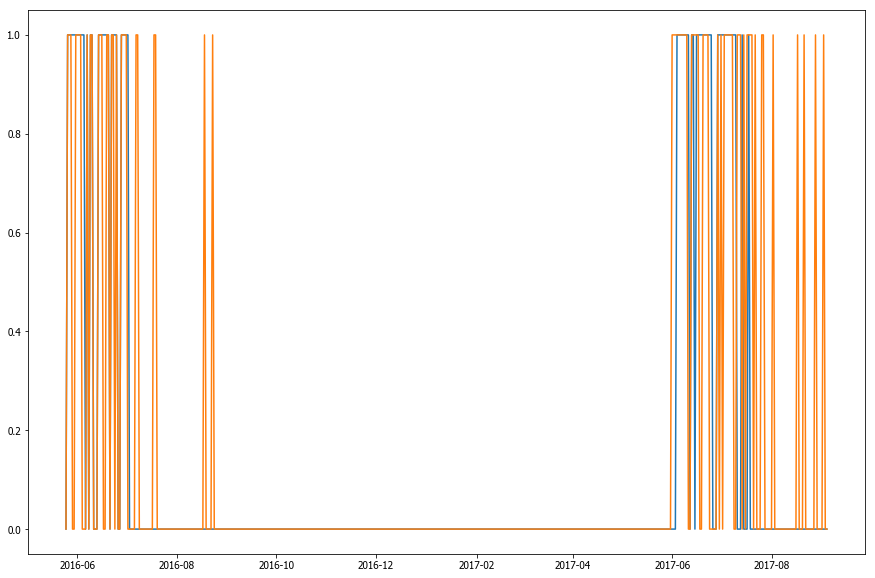

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(labels_test.index, y_pred)
plt.plot(labels_test.index, y_test)